# IntelliLog-AI | Notebook 03: Route Optimization (Graph + DSA)


# Objective:
---------
Implement and visualize graph-based route optimization algorithms that minimize delivery time.

# This notebook demonstrates:
1. Building a weighted graph of delivery nodes.
2. Finding the shortest or optimal route using Dijkstra, A*, and OR-Tools.
3. Combining ML-predicted delivery times with DSA path optimization.
4. Visualizing delivery routes on a map.

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))  

import networkx as nx
import numpy as np
import pandas as pd
import random
import folium
from itertools import permutations
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from src.features.build_features import build_features

In [2]:
df = pd.read_csv("../data/raw_orders.csv")
print("Loaded raw data:", df.shape)
df.head(3)

Loaded raw data: (500, 9)


,order_id,lat,lon,order_time,distance_km,traffic,weather,order_type,delivery_time_min
0,O00000,13.045734,77.594235,2025-10-09 02:05:18.607473,2.74,low,clear,express,5.00
1,O00001,12.966917,77.626184,2025-10-08 18:18:18.607473,10.51,low,clear,normal,24.09
2,O00002,13.026411,77.607851,2025-10-08 19:23:18.607473,0.61,high,storm,normal,5.00


In [3]:
# Pick 6 random delivery points for demo
sample_df = df.sample(6, random_state=42).reset_index(drop=True)

# Convert to coordinates
points = [(row.lat, row.lon) for _, row in sample_df.iterrows()]
print("Delivery Points (lat, lon):")
for i, (lat, lon) in enumerate(points):
    print(f"Point {i}: ({lat:.4f}, {lon:.4f})")


Delivery Points (lat, lon):
Point 0: (12.9802, 77.5909)
Point 1: (12.9581, 77.6141)
Point 2: (12.9689, 77.5751)
Point 3: (12.9333, 77.6136)
Point 4: (13.0303, 77.5510)
Point 5: (13.0738, 77.5958)


In [5]:
from geopy.distance import geodesic

n = len(points)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            dist_matrix[i, j] = geodesic(points[i], points[j]).km

print("Distance matrix (km):")
pd.DataFrame(dist_matrix).round(2)


Distance matrix (km):


,0,1,2,3,4,5
0,0.00,3.51,2.11,5.75,7.04,10.38
1,3.51,0.00,4.40,2.74,10.53,12.96
2,2.11,4.40,0.00,5.75,7.28,11.82
3,5.75,2.74,5.75,0.00,12.71,15.67
4,7.04,10.53,7.28,12.71,0.00,6.84
5,10.38,12.96,11.82,15.67,6.84,0.00


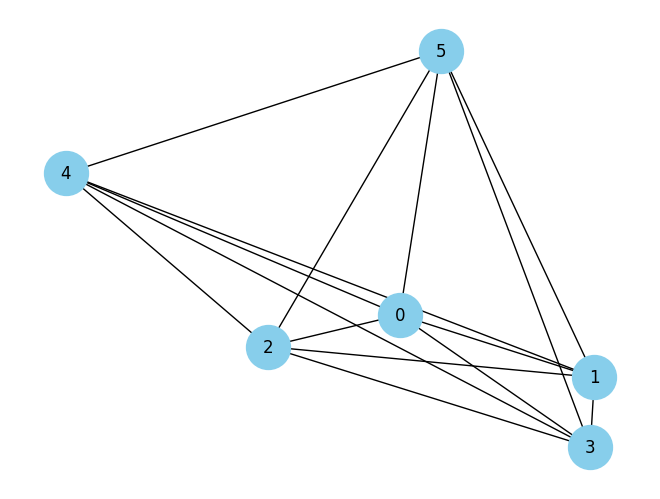

In [6]:
G = nx.Graph()
for i in range(n):
    G.add_node(i, pos=points[i])

for i in range(n):
    for j in range(i+1, n):
        G.add_edge(i, j, weight=round(dist_matrix[i,j], 2))

pos = {i: (points[i][1], points[i][0]) for i in range(n)}  # lon, lat
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=1000)


In [8]:
# Pick random start & end
start, end = 0, n-1
path = nx.dijkstra_path(G, start, end, weight="weight")
length = nx.dijkstra_path_length(G, start, end, weight="weight")

print(f"Dijkstra shortest path from {start} → {end}: {path}")
print(f"Total distance: {length:.2f} km")


Dijkstra shortest path from 0 → 5: [0, 5]
Total distance: 10.38 km


In [9]:
path_a = nx.astar_path(G, start, end, heuristic=lambda u, v: dist_matrix[u][v], weight="weight")
length_a = nx.path_weight(G, path_a, weight="weight")

print(f"A* path from {start} → {end}: {path_a}")
print(f"Total distance: {length_a:.2f} km")


A* path from 0 → 5: [0, 5]
Total distance: 10.38 km


In [12]:
start_point = points[start]
end_point = points[end]

m = folium.Map(location=start_point, zoom_start=12)
folium.Marker(start_point, tooltip="Start", icon=folium.Icon(color="green")).add_to(m)
folium.Marker(end_point, tooltip="End", icon=folium.Icon(color="red")).add_to(m)

# Draw route path
for i in range(len(path) - 1):
    folium.PolyLine(
        [points[path[i]], points[path[i+1]]],
        color="blue", weight=3, opacity=0.8
    ).add_to(m)

m


In [13]:
# Prepare distance callback
def create_data_model():
    data = {'distance_matrix': (dist_matrix * 1000).astype(int), 'num_vehicles': 1, 'depot': 0}
    return data

data = create_data_model()

manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

solution = routing.SolveWithParameters(search_params)

if solution:
    route = []
    index = routing.Start(0)
    while not routing.IsEnd(index):
        route.append(manager.IndexToNode(index))
        index = solution.Value(routing.NextVar(index))
    route.append(manager.IndexToNode(index))
    print("Optimal OR-Tools route:", route)
else:
    print(" No solution found.")


Optimal OR-Tools route: [0, 5, 4, 2, 3, 1, 0]


In [14]:
from joblib import load
model_path = "../models/xgb_delivery_time_model.pkl"
model_data = load(model_path)
model = model_data["model"]
features = model_data["features"]

# Predict delivery time for each edge
predicted_times = []
for i, j in zip(path[:-1], path[1:]):
    distance_km = dist_matrix[i][j]
    sample = pd.DataFrame([{
        "distance_km": distance_km,
        "hour": random.randint(8, 22),
        "day_of_week": random.randint(0, 6),
        "traffic_enc": random.choice([0, 1, 2]),
        "weather_enc": random.choice([0, 1, 2]),
        "order_type_enc": random.choice([0, 1]),
        "dist_x_traffic": distance_km * (1 + 0.3 * random.choice([0, 1, 2]))
    }])
    predicted = model.predict(sample[features])[0]
    predicted_times.append(predicted)

print("Predicted delivery times along path:")
for i, (a, b, t) in enumerate(zip(path[:-1], path[1:], predicted_times)):
    print(f"Segment {a} → {b}: {t:.2f} min")

print(f"Total Predicted Delivery Time: {sum(predicted_times):.2f} min")


Predicted delivery times along path:
Segment 0 → 5: 25.84 min
Total Predicted Delivery Time: 25.84 min


In [15]:
print("Route Optimization Summary")
print("-----------------------------")
print(f"Number of locations: {n}")
print(f"Shortest Path (Dijkstra): {path}")
print(f"Total distance: {length:.2f} km")
print(f"ML-Predicted Total Delivery Time: {sum(predicted_times):.2f} min")
print("Algorithm Comparison:")
print(" - Dijkstra: deterministic shortest route")
print(" - A*: uses heuristic → faster")
print(" - OR-Tools: full route optimization (vehicle routing problem)")


Route Optimization Summary
-----------------------------
Number of locations: 6
Shortest Path (Dijkstra): [0, 5]
Total distance: 10.38 km
ML-Predicted Total Delivery Time: 25.84 min
Algorithm Comparison:
 - Dijkstra: deterministic shortest route
 - A*: uses heuristic → faster
 - OR-Tools: full route optimization (vehicle routing problem)
